# Labelled timeseries
Util functions to plot timeseries. 

## Example
Here, each row is a timeseries. A row (timeseries) has a label and values for multiple timesteps (columns).

```
  label, t0, t1, ..., tN
------------------------
label_0, . , . ,    , .
label_0, . , . ,    , .
label_0, . , . ,    , .
 ...
label_M, . , . ,    , .
label_M, . , . ,    , .
label_M, . , . ,    , .
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches, colors
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Debugger
from IPython.core.debugger import Pdb
t = Pdb().set_trace

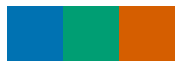

In [3]:
# Seaborn settings for nice plots
sns.set_style('dark')
sns.set_context('poster')
colors_example = sns.color_palette('colorblind', 3)
sns.palplot(colors_example)

In [4]:
# Utility functions to generate time series data
np.random.seed(22)

def generate_data(period, num_series, num_points, var):
    t = np.linspace(0, num_points/2, num_points)
    random_means = np.random.rand(num_series, num_points) # a random mean for each serie
    random_var = var * np.random.randn(num_series, 1)
    data = random_means + random_var + np.sin(t * period)
    return data
    

def generate_series(num_labels, num_series_per_label, num_points_per_series):
    var = 0.5
    dfs = []
    for label in range(num_labels):
        period = label + 1
        data = generate_data(period, num_series_per_label, num_points_per_series, var)
        df = pd.DataFrame(data=data, columns=['t%s' % i for i in range(len(data[0]))])
        labels = np.zeros(num_series_per_label, dtype=int)
        labels.fill(label)
        df['label'] = labels
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
# Utility function to reshape a dataframe
def reshape_df(df, max_rows, max_columns):
    if max_columns is not None:
        columns = list(df.columns.values)[:max_columns]
        if 'label' not in columns: 
            columns.append('label')
        df = df.loc[:, columns]
    
    if max_rows is not None:
        df = df.iloc[:max_rows]

    return df

In [6]:
# Utility function to plot groups of time series
def plot_df(df):
    
    label_names = df.label.unique()
    for label in label_names:
        data = df[df.label==label].values
        
        # Show confidence across all series 
        f, ax = plt.subplots(2, figsize=(10,5))
        sns.tsplot(data=data, ax=ax[0])

        # Plot all series
        for serie in data:
            ax[1].plot(serie)
        ax[1].set_xlim(0,len(serie)-1)


# Utility functions plot timeseries with color patches.
# Useful for timeseries with labels.
# Note on how to draw rectangles with mpl: http://matthiaseisen.com/pp/patterns/p0203 
def plot_df_labels(df, name):
    """
    Plot data, hihglight each label in different colors, and add a legend.
    
    :param df: (pd.DataFrame) data to plot. Must contain a 'label' column.
    :param name: (str) name of the plot.
    """
    # Label IDs and color palette
    label_names = sorted(df.label.unique())
    palette = sns.color_palette('colorblind', len(label_names))  
    
    # Plot color palette legend
    plot_palette_legend(palette, label_names, 'Labels of %s' %name, alpha=0.5, size=0.5)

    # Features
    columns = list(df.columns.values)
    if 'label' in columns: columns.remove('label')
    nb_columns = len(columns)
    
    # Plot data
    fig, ax = plt.subplots(nrows=nb_columns, ncols=1, 
                           figsize=(10, nb_columns* 2))
    
    for i in range(nb_columns):
        column_name = columns[i]
        values = df[column_name].values
        labels = df.label.values
        ax[i].plot(values)
        add_patches(ax[i], values, labels, label_names, palette, alpha=0.5)
        ax[i].set_ylabel(column_name)
    plt.tight_layout()
    

def plot_palette_legend(palette, label_names, title, alpha=0.5, size=0.5):
    """
    Plot the values in a color palette as a horizontal array.

    palette: sequence of matplotlib colors as returned by seaborn.color_palette()
    size: scaling factor for size of plot
    """
    n = len(palette)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size), )
    ax.imshow(np.arange(n).reshape(1, n),
              alpha=alpha,
              cmap=colors.ListedColormap(palette),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels([])
    ax.set_title(title, loc='left')


def add_patches(ax, values, labels, label_ids, palette, alpha=0.5):
    """
    Highlight each label with different color patches.
    """
    minval = min(values)
    maxval = max(values) 
    ax.set_xlim(0, len(values)-1)
    ax.set_ylim(minval, maxval)
    
    start = 0
    curr_label = labels[0]
    # Print patches when the label changes
    for t in range(len(values)):
        label = labels[t]
        if label != curr_label:
            end = t
            color_idx = label_ids.index(curr_label)
            color = palette[color_idx]
            ax.add_patch(patches.Rectangle((start, minval), # (x, y)
                                            end-start, # width
                                            maxval-minval, # height
                                            alpha=alpha, 
                                            color=color))
            start = end
            curr_label = label

    # Print the last patch
    end = t
    color_idx = label_ids.index(curr_label)
    color = palette[color_idx]
    ax.add_patch(patches.Rectangle((start, minval), # (x, y)
                                    end-start, # width
                                    maxval-minval, # height
                                    alpha=alpha, 
                                    color=color))

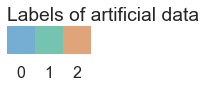

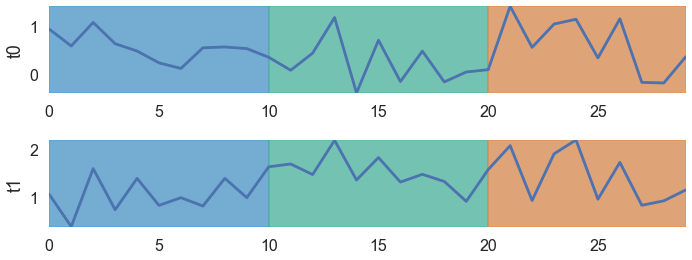

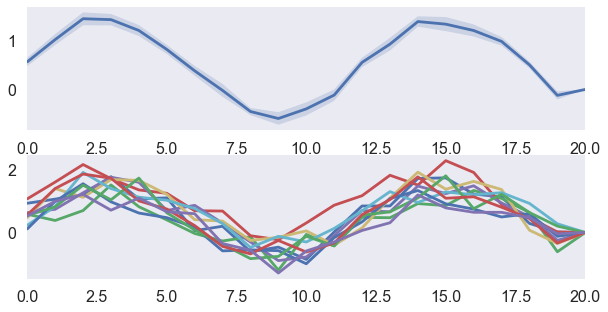

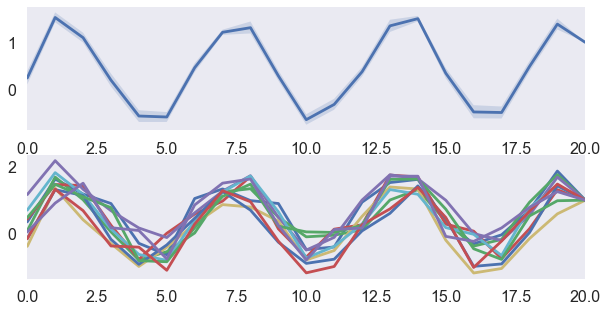

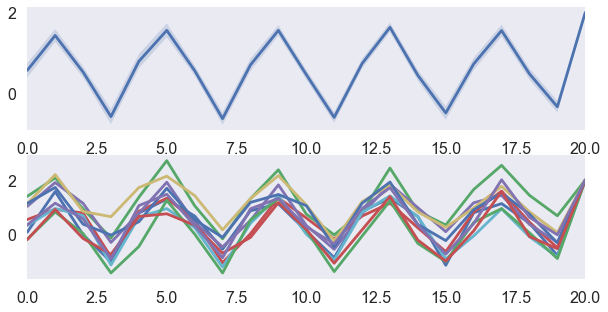

In [9]:
# Example with artificial data
num_labels = 3   
num_series_per_label = 10
num_points_per_series = 20
df = generate_series(num_labels, num_series_per_label, num_points_per_series)

max_rows = None
max_columns = 2
df1 = reshape_df(df, max_rows, max_columns)
plot_df_labels(df1, 'artificial data')

max_rows = None
max_columns = None
df2 = reshape_df(df, max_rows, max_columns)
plot_df(df2)